# Entraînement des modèles

In [1]:
import torch.nn as nn
import sklearn
import torch
import pickle
import os
import time
from tqdm import tqdm
from joblib import Parallel, delayed
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda")

In [ ]:
train_dataset=pickle.load(open('train_dataset_1.pickle','rb'))

output_=torch.stack([train_dataset[i][-1] for i in range(len(train_dataset))])
mask_cls_=torch.stack([train_dataset[i][-2] for i in range(len(train_dataset))])
output_2=torch.mul(torch.div(output_-torch.min(output_),torch.max(output_)-torch.min(output_)),mask_cls_)
output_2

K=1000
train_2=TensorDataset(torch.stack([train_dataset[i][0] for i in range(K)]),
                      torch.stack([train_dataset[i][1] for i in range(K)]),
                      torch.stack([train_dataset[i][2] for i in range(K)]),
                      torch.stack([train_dataset[i][3] for i in range(K)]),
                      output_2[:K])

batch_size=int(1024/8/8)
print(batch_size)

dataloader_2 = DataLoader(
            train_2,
            sampler = RandomSampler(train_2),
            batch_size = batch_size)

In [2]:
dataloader_2=pickle.load(open('train_loader_2.pickle','rb'))
print("Nombre de batchs :",len(dataloader_2))
for _,batch in enumerate(dataloader_2):
    print("Taille du batch :",len(batch[0]))
    break

Nombre de batchs : 2095
Taille du batch : 64


In [3]:
for batch in dataloader_2:
    break

In [4]:
batch[0][0]

tensor([    5,    39,  2486,   379,  1678,  2878, 11355,   593,  8329,     6,
            5,   460, 11824,   757,  1079,    75,   952,    39,  2708,   379,
         9507,  1555, 11049,    87,  1567,  1678,  2878, 11355,  1206,  4353,
         7974,   339,   857,     6,     5,   209,  2080,  6867,  2479,  4548,
         2751,    39,  3054,  3710,  8601,  3508,  1678,  2071,   795,    99,
          355,  8211,   379,  1678,   951,  7709,  1106, 11980,  2370,     6,
            5,   293,  8021,   131,   695,   243,  2660,  2758,  3112,  3508,
           98,  1206,   423,  1032,   232,   720,  1099,     6,     5,  1678,
         2878, 11355,  4272,   991,    59,   378,   638,   939,   238,   177,
         6060,   249,    75,  1678,  5590,    98,   108,  8217,  8519,    40,
         2836,   167,  2298,  1047,  2310,    99,    40,  6794,    98,   354,
         8371,  5395,  2467,  1219,   951,  1106, 11980,  2370,  3306,    94,
         2134,  8793,   722,    87,  8329,  7645,   243,  2298, 

In [3]:
class F1_score:
    """
    Class for f1 calculation in Pytorch.
    """

    def __init__(self):#, average: str = 'weighted'):
        """
        Init.

        Args:
            average: averaging method
        """

        #self.average = average
        #if average not in [None, 'micro', 'macro', 'weighted']:
         #   raise ValueError('Wrong value of average parameter')
    @staticmethod
    def true_positive_mean(x,y) -> torch.tensor:
        '''
        Caclul le nombre moyen de vrai positif de la prediction x par rapport aux labels y (binaires).
        '''
        tp=torch.mul(x,y).sum()
        tpm=torch.div(tp,y.shape[0])
        return tpm
    @staticmethod
    def false_positive_mean(x,y) -> torch.tensor:
        '''
        Caclul le nombre moyen de faux négatif de la prediction x par rapport aux labels y (binaires).
        '''
        device=y.device
        fp=torch.sub(x,y)
        fp=torch.max(fp,torch.tensor([0.]).to(device))
        fp=fp.sum().float()
        fpm=torch.div(fp,y.shape[0])
        return fpm
    @staticmethod
    def false_negative_mean(x,y) -> torch.tensor:
        '''
        Caclul le nombre moyen de faux négatif de la prediction x par rapport aux labels y (binaires).
        '''
        fn=torch.sub(y,x)
        device=y.device
        fn=torch.max(fn,torch.tensor([0.]).to(device))
        fn=fn.sum().float()
        fnm=torch.div(fn,y.shape[0])
        return fnm
    #@staticmethod
    def precision(self,x,y) -> torch.tensor:
        device=y.device
        tp=self.true_positive_mean(x,y)
        fp=self.false_positive_mean(x,y)
        if (tp+fp)!=0:
            prec=torch.div(tp,(tp+fp))
            return prec
        else:
            return torch.tensor(0.).to(device)

    def recall(self,x,y) -> torch.tensor:
        tp=self.true_positive_mean(x,y)
        fn=self.false_negative_mean(x,y)
        rec=torch.div(tp,(tp+fn))
        return rec
    def __call__(self,x,y) -> torch.tensor:
        device=y.device
        rec=self.recall(x,y)
        prec=self.precision(x,y)
        f1=torch.mul(rec,prec)
        f1=torch.mul(2,f1)
        f1=torch.div(f1,prec+rec)
        if (prec+rec)!=0:
            return f1#prec,rec,
        else:
            return torch.tensor(0.).to(device)#prec,rec,

        
class Weighted_Loss:
    '''
    Fonction permettant de calculer la fonction de perte Mean Absolute Error mais pondérée par des poids.
    '''
    def __init__(self,weight,loss_type='L1',binary=True):
        '''
        On initialise notre fonction de perte :
        @weight : les poids que vous voulez pour chaque classe (dim=nombre de classe)
        '''
        self.weights=weight
        self.loss_type=loss_type
        self.binary=binary
        
    def Weighted_L1(self,y_hat,y) -> torch.Tensor:
        '''
        On calcule la fonction :
        @y_hat : les prédictions du modèle
        @y : les vraies valeurs
        
        Attention, dim(y_hat)==dim(y)
        '''
        if y_hat.shape!=y.shape:
            raise ValueError("Attention, les deux inputs n'ont pas la même dimension !")
        #On met les deux tensors sur le même service (ici GPU)
        device_yhat=y_hat.device
        device_y=y.device
        if device_yhat!=device_y:
            y.to(device_yhat)
        
        w=torch.repeat_interleave(self.weights[0].clone().detach(),y.shape[1])
        w=w.repeat(y.shape[0],1)
                
        if self.binary:
            w[torch.arange(y.shape[0],dtype=torch.long).unsqueeze(1),torch.topk(y,3)[1]]=self.weights[1]
        
        else: #On surpondère les indices qui représentent les phrases, puisque c'est cela que le modèle doit prédire
            x=torch.nonzero(y!=torch.tensor(0))#.nonzero()
            x_2=torch.index_select(x,1,torch.tensor(1).to(device_yhat)).reshape(-1).to(device_yhat)
            x_1=torch.nonzero(x_2==0).to(device_yhat)#.nonzero()
            sha=torch.arange(y.shape[0],dtype=torch.long).unsqueeze(1).to(device_yhat)
            
            for k in range(len(x_1)):
                if k<(len(x_1)-1):
                    w[sha[k],x_2[x_1[k]:x_1[k+1]]]=self.weights[1]
                else:
                    w[sha[k],x_2[x_1[k]:]]=self.weights[1]
               
        sum_weights=w.sum()
        w=w.to(device_yhat)
        sum_weights=sum_weights.to(device_yhat)
        errors=torch.sub(y,y_hat)
        errors=torch.abs(errors)
        weighted_errors=torch.mul(w,errors)
        sum_weighted_errors=weighted_errors.sum()
        WMAE=torch.div(sum_weighted_errors,sum_weights)
        #WMAE.requires_grad=True
        return Variable(WMAE,requires_grad=True)#,sum_weighted_errors,sum_weights
    
    def Weighted_Sum(self,y_hat,y) -> torch.Tensor:
        '''
        Calcule la somme pondérée de la différence de la prédiction du modèle et du vecteur cible.
        '''
        if y_hat.shape!=y.shape:
            raise ValueError("Attention, les deux inputs n'ont pas la même dimension !")
        
        #On met les deux tensors sur le même service (ici GPU)
        device_yhat=y_hat.device
        device_y=y.device
        if device_yhat!=device_y:
            y.to(device_yhat)
        
        w=torch.repeat_interleave(self.weights[0].clone().detach(),y.shape[1])
        w=w.repeat(y.shape[0],1)
        
        if self.binary:
            w[torch.arange(y.shape[0],dtype=torch.long).unsqueeze(1),torch.topk(y,3)[1]]=self.weights[1]
        
        else: #On surpondère les indices qui représentent les phrases, puisque c'est cela que le modèle doit prédire
            x=torch.nonzero(y!=torch.tensor(0))#.nonzero()
            x_2=torch.index_select(x,1,torch.tensor(1).to(device_yhat)).reshape(-1).to(device_yhat)
            x_1=torch.nonzero(x_2==0).to(device_yhat)#.nonzero()
            sha=torch.arange(y.shape[0],dtype=torch.long).unsqueeze(1).to(device_yhat)
            
            for k in range(len(x_1)):
                if k<(len(x_1)-1):
                    w[sha[k],x_2[x_1[k]:x_1[k+1]]]=self.weights[1]
                else:
                    w[sha[k],x_2[x_1[k]:]]=self.weights[1]
                    
        w=w.to(device_yhat)
        y_diff=torch.abs(torch.sub(y,y_hat))
        y_diff_pond=torch.mul(y_diff,w)
        sum_y_diff_pon=torch.div(torch.sum(y_diff_pond),y_hat.shape[0])
        return Variable(sum_y_diff_pon,requires_grad=True)
    
    def __call__(self,y_hat,y) -> torch.Tensor:
        if self.loss_type=='L1':
            loss=self.Weighted_L1(y_hat,y)
            return loss
        elif self.loss_type=='sum':
            loss=self.Weighted_Sum(y_hat,y)
            return loss
        else:
            raise ValueError("Attention, veuillez bien spécifier un type de perte.\nSeules les valeurs 'L1' ou 'sum' sont acceptées.")

In [ ]:
!pip install transformers

In [4]:
from transformers import CamembertModel,CamembertConfig,AdamW
camem1=CamembertModel(CamembertConfig())
camem2=CamembertModel.from_pretrained("camembert-base")

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
class Simple_Classifier(nn.Module):
    def __init__(self, hidden_size):
        super(Simple_Classifier, self).__init__()
        self.linear1 = nn.Linear(hidden_size, 1)
        self.relu=nn.LeakyReLU(negative_slope= 0.01)

    def forward(self, x):
        x.requires_grad_(True)
        h = self.linear1(x).squeeze(-1)
        sent_scores = self.relu(h)
        return sent_scores.squeeze(-1)

class Multi_Linear_Classifier(nn.Module):
    def __init__(self, hidden_size):
        super(Multi_Linear_Classifier, self).__init__()
        self.linear1 = nn.Linear(hidden_size, int(hidden_size/2))
        self.linear2 = nn.Linear(int(hidden_size/2),int(hidden_size/6))
        self.linear3 = nn.Linear(int(hidden_size/6),1)
        self.Lrelu=nn.LeakyReLU(negative_slope= 0.01)
        self.softmax=nn.Softmax(dim=-1)


    def forward(self, x):#, mask_cls):
        x.requires_grad_(True)
        h = self.linear1(x).squeeze(-1)
        h = self.softmax(h)#self.Lrelu(h) #* mask_cls.float()
        h = self.linear2(h)
        h = self.softmax(h)#self.Lrelu(h)
        h = self.linear3(h)
        #h = self.softmax(h)#self.Lrelu(h)
        return h.squeeze(-1)
    

class SMHA_classifier(nn.Module):
    def __init__(self, size,nhead):
        super(SMHA_classifier, self).__init__()
        self.MHA = nn.MultiheadAttention(size[1], nhead)
        self.LReLu=nn.LeakyReLU(negative_slope= 0.01)
        self.sigmoid = nn.Sigmoid()
        self.LN=nn.LayerNorm(size)

    def forward(self, x):
        x.requires_grad_(True)
        h,weights = self.MHA(x,x,x)
        normalized_h=self.LN(h)
        sent_scores = self.LReLu(normalized_h) #* mask_cls.float()
        return sent_scores.mean(dim=2)
    
class SMHA_Linear_classifier(nn.Module):
    def __init__(self, size,nhead,hidden_size):
        super(SMHA_Linear_classifier, self).__init__()
        self.MHA = nn.MultiheadAttention(size[1], nhead)
        self.LReLu=nn.LeakyReLU(negative_slope= 0.01)
        self.sigmoid = nn.Sigmoid()
        self.LN=nn.LayerNorm(size)
        self.linear1 = nn.Linear(hidden_size, int(hidden_size/2))
        self.linear2 = nn.Linear(int(hidden_size/2),int(hidden_size/6))

    def forward(self, x):
        x.requires_grad_(True)
        h,weights = self.MHA(x,x,x)
        h=self.LN(h)
        h=self.linear1(h)
        h=self.LReLu(h)
        h=self.linear2(h)
        sent_scores = self.LReLu(h) #* mask_cls.float()
        return sent_scores.mean(dim=2) 
    

class Net(nn.Module):
    def __init__(self,k1,k2,k3,s1,s2,s3):
        super().__init__()
        self.conv1 = nn.Conv1d(512, 512, kernel_size=k1,stride=s1)
        self.pool = nn.MaxPool1d(k2, s2)
        self.conv2 = nn.Conv1d(512, 512, kernel_size=k3,stride=s3)
        self.dim=int((768-k1)/s1)+1
        self.dim=int((self.dim-(k2-1)-1)/s2+1)
        self.dim=int((self.dim-k3)/s3)+1
        self.fc1 = nn.Linear(self.dim, int(self.dim/2))
        self.fc2 = nn.Linear(int(self.dim/2), int(self.dim/8))
        self.fc3 = nn.Linear(int(self.dim/8), 1)
        self.LReLu=nn.LeakyReLU(negative_slope= 0.01)
        self.softmax=nn.Softmax(dim=-1)

    def forward(self, x):
        x.requires_grad_(True)
        x = self.pool(self.LReLu(self.conv1(x)))
        x =self.LReLu(self.conv2(x))
        #x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.LReLu(self.fc1(x))
        x = self.LReLu(self.fc2(x))
        x = self.fc3(x)
        #x=self.softmax(x)
        return x.flatten(1)


## Vérification de fonctionnement des modèles et optimiseurs 

In [76]:
mlc=Multi_Linear_Classifier(camem2.config.hidden_size)
mlc_optimizer_SGD=optim.SGD(mlc.parameters(), lr=0.001, momentum=0.09)
mlc_optimizer_Adam=optim.AdamW(convnet.parameters(), lr=0.009, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

slc=Simple_Classifier(camem2.config.hidden_size)
slc_optimizer=optim.AdamW(slc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
#SGD(slc.parameters(), lr=0.001, momentum=0.09)

att_c=SMHA_classifier(torch.Size([512,768]),8)
att_c_optimizer=optim.SGD(att_c.parameters(), lr=0.001, momentum=0.09)

att_lin_c=SMHA_Linear_classifier(torch.Size([512,768]),8,768)
att_lin_c_optimizer=optim.SGD(att_lin_c.parameters(), lr=0.001, momentum=0.09)

convnet=Net(2**8,2**6,2,2,2,2)
convnet_optimizer=optim.AdamW(convnet.parameters(), lr=0.009, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
#SGD(convnet.parameters(), lr=0.001, momentum=0.09)

In [ ]:
input=torch.rand(16,512,768).to(device)
output=torch.rand(16,512).to(device)

for m,o in zip([mlc,slc,att_c,att_lin_c,convnet],[mlc_optimizer_Adam,slc_optimizer,att_c_optimizer,att_lin_c_optimizer,convnet_optimizer]):
    print("\n Modèle :",str(m).split('(')[0],'\n')
    
    model=m.to(device)
    param1=list(model.parameters())[0].clone()

    sortie=model(input)

    for l in [nn.MSELoss(),loss_2,loss_3]:
        ouais=l(sortie,output)
        o.zero_grad()
        ouais.backward(retain_graph=True)
        o.step()
        
        param2=list(model.parameters())[0].clone()
        print("For loss,",l,"Did the grad updated the weights ?",bool(1-torch.equal(param1.data,param2.data)))

the learning rate has to be smaller for mini-batch learning, because the smaller the batch size the larger the gradient variance you have which can cause bad optimization steps when the step size is not decreased.

Stochastic gradient descent usually oscillate heavily between different loss function values and would asymptotically decrease with lower step size. The convergence rate of stochastic gradient descent depends heavily on the step size [1].

With full-batch gradient descent, you have the full gradient information of the batch which allows you to take a bigger step size without risking having "bad" optimization steps.

In [ ]:
k=4
input=torch.rand(k,16,512,768).to(device)
output_ex=torch.rand(k,16,512).to(device)

epochs=k
#step=2

#convnet=Net(2**8,2**6,2,2,2,2)
#convnet_optimizer=optim.AdamW(convnet.parameters(), lr=0.009, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

l=loss_3#nn.MSELoss()

#model=convnet.to(device)
#o=convnet_optimizer

param=[]
param.append(list(model.parameters())[0].clone())

#loss=0
model.zero_grad()

for e in range(epochs):
    sortie=model(input[e])

    ouais=l(sortie,output_ex[e])
    #loss+=ouais
    ouais.backward()#retain_graph=True)
    
    #if e%step==0:
    optimizer.step()

    for par in model.parameters():
        print(par.grad.data.sum())

    # start debugger
    #import pdb; pdb.set_trace()
    print("\n")
    optimizer.zero_grad()

    for par in model.parameters():
        print(par.grad.data.sum())

    param.append(list(model.parameters())[0].clone())
    z=int(e)
    print("\nFor epoch,",z,"Did the grad updated the weights ?",bool(1-torch.equal(param[z].data,param[z+1].data)),"\n")

In [75]:
for step, batch in enumerate(data):
    input_id = batch[0]#.to(device)
    mask = batch[1]#.to(device)
    clss = batch[2].float().to(device)
    mask_cls=batch[3]#.to(device)
    output=batch[4].float().to(device)
    #[list(model.parameters())[i].clone() for i in range(len(list(model.parameters())))]
    param1=list(model.parameters())[0].clone()
    if step>0:
        break

topvec=camem2(input_id,mask)
topvec=topvec.last_hidden_state.to(device)

sortie=model(topvec)

ouais=loss(sortie,output)
ouais.backward()
optimizer.step()
optimizer.zero_grad()

param=list(model.parameters())[0].clone()
print("Did the grad updated the weights ?",bool(1-torch.equal(param1.data,param.data)))

Did the grad updated the weights ? True


In [7]:
import gc
def check_weights_update(model,loss,optim,dev=False):
    param1=list(model.parameters())[0].clone()
    input=torch.rand(torch.Size([3,512,768]))
    target=torch.rand(torch.Size([3,512]))
    
    if dev:
        input=input.to(torch.device('cuda'))
        target=target.to(torch.device('cuda'))
    
    sortie=model(input)
    optim.zero_grad()
    ouais=loss(sortie,target)
    ouais.backward()
    optim.step()
    param=list(model.parameters())[0].clone()
    out=bool(1-torch.equal(param1.data,param.data))
    del input,target,sortie,ouais
    gc.collect()
    torch.cuda.empty_cache()
    return out
#check_weights_update(Models[0],Loss[0],Optimizers[0])

In [ ]:
model.train()
check_weights_update(model,loss,optimizer)

### Gestion mémoire (si besoin)

In [17]:
#del loss_train_3,optimizer,model,slc,mlc,att_c, att_lin_c,convnet
del slc
import gc
gc.collect()
torch.cuda.empty_cache()

t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0) 
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
r

## Définition des modèles et fonction de perte et entraînement

In [8]:
mlc=Multi_Linear_Classifier(camem2.config.hidden_size)
#mlc_optimizer_SGD=optim.SGD(mlc.parameters(), lr=0.001, momentum=0.09)

#slc=Simple_Classifier(camem2.config.hidden_size)
#slc_optimizer=optim.AdamW(slc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
#SGD(slc.parameters(), lr=0.001, momentum=0.09)

#att_c=SMHA_classifier(torch.Size([512,768]),8)
#att_c_optimizer=optim.SGD(att_c.parameters(), lr=0.001, momentum=0.09)

#att_lin_c=SMHA_Linear_classifier(torch.Size([512,768]),8,768)
#att_lin_c_optimizer=optim.AdamW(att_lin_c.parameters(), lr=0.0009, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
#SGD(att_lin_c.parameters(), lr=0.001, momentum=0.09)

#convnet=Net(2**8,2**6,2,2,2,2)
#convnet_optimizer=optim.AdamW(convnet.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
#SGD(convnet.parameters(), lr=0.001, momentum=0.09)

score=F1_score()

alpha=0.1
weights=torch.Tensor([(1/(1-alpha))*1/((512-20)/512),(1/alpha)*1/((20)/512)])
#weights=torch.Tensor([(1/(1-alpha))*1/((1)/512),(1/alpha)*1/((512-1)/512)])
#weights=torch.Tensor([1,1])
print(weights)
loss_3=Weighted_Loss(weight=weights,loss_type='sum',binary=False)
loss_2=Weighted_Loss(weight=weights,loss_type='L1',binary=False)
loss=nn.MSELoss()#nn.L1Loss()
epochs=10
model=mlc.to(device)
#model
mlc_optimizer_Adam=optim.AdamW(model.parameters(), lr=0.009, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
optimizer=mlc_optimizer_Adam
data=dataloader_2

model.train()
print(check_weights_update(model,loss,optimizer,dev=True),check_weights_update(model,loss_2,optimizer,dev=True),check_weights_update(model,loss_3,optimizer,dev=True))

tensor([  1.1563, 256.0000])
True True True


### Boucle d'entraînement

In [9]:
model=SMHA_Linear_classifier(torch.Size([512,768]),8,768)
path='SMHA_Linear_classifier.pt'
model.load_state_dict(torch.load(path))
model.to(device)

optimizer=optim.AdamW(model.parameters(), lr=0.0009, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
optimizer.load_state_dict(torch.load(path[:-3]+'_AdamW.pt'))

model.train()
check_weights_update(model,loss,optimizer,dev=True)

True

In [ ]:
#Pour enregistrer les informations de l'entraînement
training_stats = []
score_stat=[]

#loss.requires_grad=True
#pred_output={}

# Boucle d'entrainement
camem2.to('cpu')
#model.train()
#model.to(device)
model.zero_grad()
print("Entraînement du modèle :",str(model).split('(')[0])
start=time.time()

for epoch in range(0, epochs):

    # On initialise la loss pour cette epoque
    total_train_loss = 0
    total_train_loss_2 = 0
    total_train_loss_3 = 0
    f1_score=0
    prec_score=0
    #pred=[]
    # On met le modele en mode 'training'
    # Dans ce mode certaines couches du modele agissent differement

    # Pour chaque batch
    for step, batch in enumerate(tqdm(data)):

        # On recupere les donnees du batch
        input_id = batch[0]#.to(device)
        mask = batch[1]#.to(device)
        clss = batch[2].float().to(device)
        mask_cls=batch[3]#.to(device)
        output=batch[4].float().to(device)

        param1=list(model.parameters())[0].clone()
        
        # On met le gradient a 0
        optimizer.zero_grad()#summa_parallel.zero_grad()        
 
        # On passe la donnee au model et on recupere la loss et le logits (sortie avant fonction d'activation)
        topvec=camem2(input_id,mask)
        topvec=topvec.last_hidden_state.to(device)
        #topvec=topvec.mul(mask_cls.unsqueeze(2)).to(device)
        
        sortie=model(topvec)
        
        #On calcule et garde le score pour information, mais le détache pour éviter de faire exploser la mémoire
        f1_score+=score(sortie,output).detach().item()
        prec_score+=score.precision(sortie,output).detach().item()

        #output2=make_output_topk(output,k=1).long().to(device)
        loss_train=loss(sortie,output).detach().item() # on commente detach sur la loss par rapport à laquelle on veut optimiser
        loss_train_2=loss_2(sortie,output).detach().item()
        loss_train_3=loss_3(sortie,output)#.detach().item()
        
        # Backpropagtion
        loss_train_3.backward()
        # On actualise les paramètres grace a l'optimizer
        optimizer.step()
        
        # Checks if the weights did update, if not, informs at which step
        param2=list(model.parameters())[0].clone()
        check=bool(1-torch.equal(param1.data,param2.data))
        if check==False:
            print("The weights did not update at batch",step,"epoch",epoch)        
        
        # Keep all the predictions
        #pred.append(sortie.detach())

        # .item() donne la valeur numerique de la loss
        total_train_loss += loss_train#.detach().item() 
        total_train_loss_2 += loss_train_2#.detach().item() 
        total_train_loss_3 += loss_train_3.detach().item() 

    # On calcule les statistiques et les pertes moyennes sur toute l'epoque
    f1_stat=f1_score/len(data)
    prec_stat=prec_score/len(data)
    avg_train_loss = total_train_loss / len(data)   
    avg_train_loss_2 = total_train_loss_2 / len(data)   
    avg_train_loss_3 = total_train_loss_3 / len(data)   

    print("\nAverage training loss MSE: {0:.4f}".format(avg_train_loss),
          "\nAverage training loss L1: {0:.4f}".format(avg_train_loss_2),
          "\nAverage training loss sum: {0:.4f}".format(avg_train_loss_3),
          "\nAverage f1 score: {0:.4f}".format(f1_stat),
          "\nAverage precision score: {0:.4f}".format(prec_stat))  
     
    # Enregistrement des stats de l'epoque
    training_stats.append(
        {'epoch': epoch + 1,
        'Training Loss MSE': avg_train_loss,
        'Training Loss L1': avg_train_loss_2,
        'Training Loss sum': avg_train_loss_3,
        'Training f1 score': f1_stat,
        'Training precision score':prec_stat})

end=time.time()
print("L'entraînement a duré :",round((end-start)/60,2),"minutes.")

pickle.dump(training_stats,open('training_stats_'+str(model).split('(')[0],'wb'))
torch.save(model.state_dict(), str(model).split('(')[0]+".pt")
torch.save(optimizer.state_dict(), str(model).split('(')[0]+'_'+str(optimizer).split(' (')[0]+".pt")
print("Model saved!")

  0%|          | 0/2095 [00:00<?, ?it/s]

Entraînement du modèle : Multi_Linear_Classifier


 32%|███▏      | 661/2095 [1:45:54<3:44:25,  9.39s/it]

In [ ]:
training_stats

In [48]:
MSE=[]
L1=[]
S=[]
F1=[]
precision=[]
for i in range(5):
    MSE.append(training_stats[i]['Training Loss MSE'])
    L1.append(training_stats[i]['Training Loss L1'])
    S.append(training_stats[i]['Training Loss sum'])
    F1.append(training_stats[i]['Training f1 score'])
    precision.append(training_stats[i]['Training precision score'])

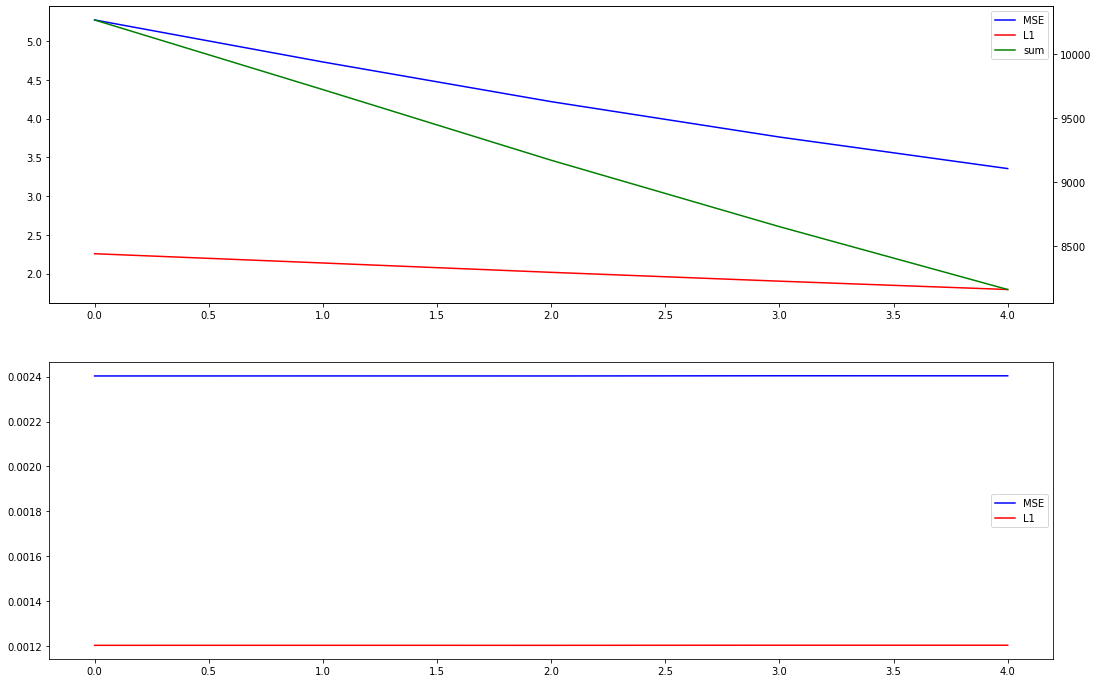

In [49]:
import matplotlib.pyplot as plt
figue,hache=plt.subplots(2,figsize=(18,12))

a,=hache[0].plot([i for i in range(5)],MSE,color='blue',label='MSE')
#hache=hache.twinx()
b,=hache[0].plot([i for i in range(5)],L1,color='red',label='L1')
hache3=hache[0].twinx()
c,=hache3.plot([i for i in range(5)],S,color='green',label='sum')
p=[a,b,c]
hache[0].legend(p,[p_.get_label() for p_ in p])

a,=hache[1].plot([i for i in range(5)],F1,color='blue',label='MSE')
#hache=hache.twinx()
b,=hache[1].plot([i for i in range(5)],precision,color='red',label='L1')
p=[a,b]
hache[1].legend(p,[p_.get_label() for p_ in p])


### Comparaison durée 

In [12]:
for step, batch in enumerate(data):
    if step==0:
        start1=time.time()
        input_id = batch[0].to(device)
        mask = batch[1].to(device)
        clss = batch[2].float().to(device)
        mask_cls=batch[3].to(device)
        output=batch[4].float().to(device)
        end1=time.time()
        print(end1-start1)
    elif step==1:
        start2=time.time()
        input_id = batch[0]#.to(device)
        mask = batch[1]#.to(device)
        clss = batch[2].float()#.to(device)
        mask_cls=batch[3]#.to(device)
        output=batch[4].float()#.to(device)
        end2=time.time()
        print(end2-start2)
    else:
        break
print((end1-start1)/(end2-start2))

0.0012509822845458984
0.00018358230590820312
6.814285714285714


In [23]:
model=convnet
optimizer=convnet_optimizer
camem2.to('cpu')
model.to(device)
total_train_loss = 0
total_train_loss_2 = 0
total_train_loss_3 = 0
f1_score=0
prec_score=0
start_total=time.time()
for step, batch in enumerate(data):
        if step==0:
            # On recupere les donnees du batch
            start=time.time()
            input_id = batch[0]#.to(device)
            mask = batch[1]#.to(device)
            clss = batch[2].float().to(device)
            mask_cls=batch[3]#.to(device)
            output=batch[4].float().to(device)
            end=time.time()
            print(end-start)
            param1=list(model.parameters())[0].clone()

            # On met le gradient a 0
            optimizer.zero_grad()#summa_parallel.zero_grad()        

            # On passe la donnee au model et on recupere la loss et le logits (sortie avant fonction d'activation)
            start=time.time()
            topvec=camem2(input_id,mask)
            topvec=topvec.last_hidden_state.to(device)
            end=time.time()
            print(end-start)
            #topvec=topvec.mul(mask_cls.unsqueeze(2)).to(device)
            start=time.time()
            sortie=model(topvec)
            end=time.time()
            print(end-start)
            
            #On calcule et garde le score pour information, mais le détache pour éviter de faire exploser la mémoire
            f1_score+=score(sortie,output).detach().item()
            prec_score+=score.precision(sortie,output).detach().item()

            #output2=make_output_topk(output,k=1).long().to(device)
            loss_train=loss(sortie,output)#.detach() # on commente detach sur la loss par rapport à laquelle on veut optimiser
            loss_train_2=loss_2(sortie,output).detach().item()
            loss_train_3=loss_3(sortie,output).detach().item()

            # Backpropagtion
            start=time.time()
            loss_train.backward()
            # On actualise les paramètres grace a l'optimizer
            optimizer.step()
            end=time.time()
            print(end-start)
end_total=time.time()
print(end_total-start_total)
  

0.0004534721374511719
16.358054876327515
0.004161357879638672
43.16815209388733
62.308534383773804


In [10]:
camem2.to('cpu')
start=time.time()
topvec=camem2(input_id,mask)
end=time.time()
print(end-start)

19.60832190513611


In [ ]:
model.to(device)
start=time.time()
model.to('cpu')
torch.cuda.empty_cache()
camem2.to(device)
camem2(input_id.to(device),mask.to(device))
camem2.to('cpu')
torch.cuda.empty_cache()
model.to(device)
end=time.time()
print(end-start)

In [20]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0) 
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
f/1024/1024/1024
print(a/1024/1024)

30.02001953125


In [ ]:
from __future__ import print_function  # for Python2
import sys

local_vars = list(locals().items())
for var, obj in local_vars:
    print(var, sys.getsizeof(obj))